In [1]:
from itertools import accumulate
import numpy as np
from scipy.signal import convolve, correlate

# from concurrent.futures import ThreadPoolExecutor
# executor = ThreadPoolExecutor(os.cpu_count())

class FullyConnectedLayer:
    def __init__(self, nIn, nOut, scale=0.5):
        self.w = np.random.normal(size=(nIn, nOut), scale=scale)
    def predict(self, x):
        return np.dot(x, self.w)
    def vjpx(self, x, y, h):
        return np.dot(h, self.w.T)
    def vjpw(self, x, y, h):
        return x[:,:,None]*h[:,None,:]
    def update(self, dw):
        self.w += dw
    def __repr__(self):
        return str(self.w)

class BiasLayer:
    def __init__(self, size):
        self.w = np.zeros(size)
    def predict(self, x):
        return x + self.w.reshape(x.shape[1:])
    def vjpx(self, x, y, h):
        return h
    def vjpw(self, x, y, h):
        return h
    def update(self, dw):
        self.w += dw.reshape(self.w.shape)
    def __repr__(self):
        return str(self.w) 

class FixedLayer:
    def vjpw(self, x, y, h):
        pass
    def update(self, dw):
        pass
    def __repr__(self):
        return self.__class__.__name__

class ReLULayer(FixedLayer):
    def predict(self, x):
        return x*(x > 0)
    def vjpx(self, x, y, h):
        return np.multiply(h, x>0)
        
class LeakyReLULayer(FixedLayer):
    def __init__(self, t=0.01):
        self.t = t
    def predict(self, x):
        return np.maximum(self.t*x, x)
    def vjpx(self, x, y, h):
        return np.multiply(h, np.where(x>0, 1., self.t))

class SigmoidLayer(FixedLayer):
    def predict(self, x):
        return 1./(1.+np.exp(-x))
    def vjpx(self, x, y, h):
        return np.multiply(h, y*(1.-y))
        
class ConvolutionalLayer:
    def __init__(self, kW, kH, scale=0.1):
        self.w = np.random.normal(size=(kW, kH), scale=scale)
    def predict(self, x):
        #return np.array(list(executor.map(lambda a: convolve(a, self.w, 'same'), x)))
        #return np.array([convolve(a, self.w, 'same') for a in x])
        return convolve(x, self.w[None,:,:], 'same')
    def vjpx(self, x, y, h):
        #return np.array(list(executor.map(lambda a: convolve(a[::-1,::-1], self.w, 'same')[::-1,::-1], h)))
        #return np.array([convolve(a[::-1,::-1], self.w, 'same')[::-1,::-1] for a in h]) 
        return convolve(h[:,::-1,::-1], self.w[None,:,:], 'same')[:,::-1,::-1]
    def vjpw(self, x, y, h):
        padded = np.zeros([i+j-1 for i,j in zip(h.shape, (1,)+self.w.shape)], dtype=h.dtype)
        slices = tuple(slice((j-1)//2, i+(j-1)//2) for i,j in zip(h.shape, (1,)+self.w.shape))
        padded[slices] = h
        #return np.array(list(executor.map(lambda a: correlate(a[0], a[1], 'valid'), zip(padded, x))))
        return np.array([correlate(a, b, 'valid') for a,b in zip(padded, x)])
    def update(self, dw):
        self.w += dw
    def __repr__(self):
        return str(self.w)

class MaxPoolingLayer(FixedLayer):
    def _reshape(self, x):
        N, H, W = x.shape
        return x.reshape(N, H//2, 2, W//2, 2)
    def predict(self, x):
        return self._reshape(x).max(axis=(2,4))
    def vjpx(self, x, y, h):
        max = np.isclose(self._reshape(x), y[:,:,None,:,None])
        result = np.zeros(max.shape)
        np.copyto(result, h[:,:,None,:,None], where=max)
        return result.reshape(x.shape)

class FlattenLayer(FixedLayer):
    def predict(self, x):
        return x.reshape(x.shape[0], -1)
    def vjpx(self, x, y, h):
        return h.reshape(x.shape)

class LeastSquaresLoss():
    def value(self, p, t):
        error = p-t
        return np.einsum('...j,...j->...', error, error)
    def grad(self, p, t):
        return 2.*(p-t)

def softmax(x, t=1.):
    e = np.exp(x/t)
    return e/np.sum(e, axis=-1, keepdims=True)
    
class CrossEntropyLoss():
    def __init__(self, t=1.):
        self.t = t
    def value(self, y, yoh):
        s = softmax(y, self.t)
        return -np.sum(yoh*np.log(s), axis=-1)
    def grad(self, y, yoh):
        s = softmax(y, self.t)
        return s-yoh

def predict(layers, x):
    return list(accumulate(layers, lambda total, layer: layer.predict(total), initial=x))

def backprop(layers, xs, h):
    result = []
    for layer, x, y in zip(layers[::-1], xs[-2::-1], xs[::-1]):
        result.insert(0, layer.vjpw(x, y, h))
        h = layer.vjpx(x, y, h)
    return result

def train_batch(layers, batch, reference, cost_grad, rate=0.1):
    predictions = predict(layers, batch)
    grads = backprop(layers, predictions, cost_grad(predictions[-1], reference))
    for layer, grad in zip(layers, grads):
        if grad is not None:
            layer.update(-rate*np.mean(grad, axis=0))

def train(layers, data, reference, loss_grad):
    while True:
        epoch = yield
        lr, batch_size = epoch
        batch_indexes = np.array(range(len(data)))
        split_indexes = np.array(range(batch_size-1, len(data)-batch_size, batch_size))
        np.random.shuffle(batch_indexes)
        for batch_index in np.split(batch_indexes, split_indexes):
            batch = data[batch_index]
            reference = label2vec[labels[batch_index]]
            train_batch(layers, batch, reference, loss_grad, lr)

In [2]:
from scipy.optimize import approx_fprime

def test_predict(layer, x, y):
    assert np.all(np.isclose(layer.predict(x), y))

def test_vjpx(layer, x_shape):
    x = np.random.rand(*x_shape)
    y = layer.predict(x)
    h = np.random.rand(*y.shape)
    actual = layer.vjpx(x, y, h)
    for i in range(actual.shape[0]):
        j = approx_fprime(x[i].flatten(), lambda t: layer.predict(t.reshape((1,)+x_shape[1:])).flatten())
        assert np.all(np.isclose(actual[i], h[i].flatten().dot(j).reshape(actual.shape[1:])))

def test_vjpw(layer, x_shape):
    x = np.random.rand(*x_shape)
    y = layer.predict(x)
    h = np.random.rand(*y.shape)
    actual = layer.vjpw(x, y, h)
    if actual is None:
        return
    def tester(w):
        layer.w = w.reshape(layer.w.shape)
        return layer.predict(x).flatten()
    j = approx_fprime(layer.w.flatten(), tester).reshape((x.shape[0], -1, layer.w.size))
    expected = np.einsum('ij,ijk->ik', h.reshape((x.shape[0], -1)), j).reshape(actual.shape)
    assert np.all(np.isclose(actual, expected))

tests = [(MaxPoolingLayer(), [[[1,2,7,8], [5,6,3,4], [9,0,1,2], [3,4,7,7]]], [[[6, 8], [9, 7]]]),
         (ReLULayer(), [-1, -.1, -.01, .01, .1, 1], [0, 0, 0, .01, .1, 1])]

for layer, x, y in tests:
    assert np.all(np.isclose(layer.predict(np.asarray(x)), np.asarray(y)))
    print(layer.__class__.__name__, "predict OK")

jac_tests = [(FullyConnectedLayer(2,3), (10, 2)),
             (BiasLayer(10), (10,10)),
             (FlattenLayer(), (10,4,4)),
             (ReLULayer(), (10,10)),
             (LeakyReLULayer(), (10,10)),
             (SigmoidLayer(), (10,10)),
             (MaxPoolingLayer(), (10,4,4)),
             (ConvolutionalLayer(2,2), (10,6,6)),
             (ConvolutionalLayer(3,3), (10,8,8))]
for layer, x_shape in jac_tests:
    test_vjpx(layer, x_shape)
    test_vjpw(layer, x_shape)
    print(layer.__class__.__name__, "jacobian OK")

MaxPoolingLayer predict OK
ReLULayer predict OK
FullyConnectedLayer jacobian OK
BiasLayer jacobian OK
FlattenLayer jacobian OK
ReLULayer jacobian OK
LeakyReLULayer jacobian OK
SigmoidLayer jacobian OK
MaxPoolingLayer jacobian OK
ConvolutionalLayer jacobian OK
ConvolutionalLayer jacobian OK


In [3]:
batch = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
reference = np.array([[0], [1], [1], [0]])
loss = LeastSquaresLoss()

layers = [
    FullyConnectedLayer(2, 2, np.sqrt(2./4.)), ReLULayer(),
    FullyConnectedLayer(2, 1, np.sqrt(2./4.))]

for lr in np.power(10, np.linspace(1, 0, 10)):
    train_batch(layers, batch, reference, loss.grad, lr)

result = predict(layers, batch)[-1]
print(loss.value(result, reference))
print(np.round(result, 2))

[0. 1. 1. 0.]
[[0.]
 [0.]
 [0.]
 [0.]]


In [4]:
import struct
import gzip
from math import prod

def read_data(filename):
    with gzip.open(filename, 'rb') as f:
        z1, z2, dt, ndim = struct.unpack('BBBB', f.read(4))
        dims = struct.unpack('>'+'I'*ndim, f.read(ndim*4))
        buffer = f.read(prod(dims))
        return np.frombuffer(buffer, {8: np.ubyte}[dt]).reshape(dims)

In [5]:
data = read_data('train-images-idx3-ubyte.gz')/255.
labels = read_data('train-labels-idx1-ubyte.gz')
test_data = read_data('t10k-images-idx3-ubyte.gz')/255.
test_labels = read_data('t10k-labels-idx1-ubyte.gz')

In [6]:
label2vec = []
for i in range(10):
    x = np.zeros(10)
    x[i] = 1.0
    label2vec.append(x)
label2vec = np.array(label2vec)

layers = [
    FlattenLayer(),
    FullyConnectedLayer(784, 100, np.sqrt(1./784.)), BiasLayer(100), SigmoidLayer(),
    FullyConnectedLayer(100, 10, np.sqrt(1./100.))]
loss = CrossEntropyLoss()
batch_size = 20
epochs = 50

def train_wrapper():
    trainer = train(layers, data, labels, loss.grad)
    trainer.send(None)
    for epoch, lr in zip(range(epochs), np.power(10., np.linspace(-1, -1, epochs))):
        trainer.send((lr, batch_size))
        result = predict(layers, data)[-1]
        reference = label2vec[labels]
        l = loss.value(result, reference).mean()
        print(f'epoch {epoch+1}/{epochs} loss {l:.3} lr {lr:.3}')

train_wrapper()
#%prun -s cumtime train_wrapper()

epoch 1/50 loss 0.289 lr 0.1
epoch 2/50 loss 0.232 lr 0.1
epoch 3/50 loss 0.196 lr 0.1
epoch 4/50 loss 0.167 lr 0.1
epoch 5/50 loss 0.146 lr 0.1
epoch 6/50 loss 0.128 lr 0.1
epoch 7/50 loss 0.12 lr 0.1
epoch 8/50 loss 0.104 lr 0.1
epoch 9/50 loss 0.0931 lr 0.1
epoch 10/50 loss 0.0874 lr 0.1
epoch 11/50 loss 0.0807 lr 0.1
epoch 12/50 loss 0.0745 lr 0.1
epoch 13/50 loss 0.0681 lr 0.1
epoch 14/50 loss 0.063 lr 0.1
epoch 15/50 loss 0.0597 lr 0.1
epoch 16/50 loss 0.0559 lr 0.1
epoch 17/50 loss 0.0527 lr 0.1
epoch 18/50 loss 0.0502 lr 0.1
epoch 19/50 loss 0.046 lr 0.1
epoch 20/50 loss 0.0436 lr 0.1
epoch 21/50 loss 0.0412 lr 0.1
epoch 22/50 loss 0.0392 lr 0.1
epoch 23/50 loss 0.0378 lr 0.1
epoch 24/50 loss 0.0353 lr 0.1
epoch 25/50 loss 0.0334 lr 0.1
epoch 26/50 loss 0.0324 lr 0.1
epoch 27/50 loss 0.0311 lr 0.1
epoch 28/50 loss 0.0288 lr 0.1
epoch 29/50 loss 0.0285 lr 0.1
epoch 30/50 loss 0.0263 lr 0.1
epoch 31/50 loss 0.0257 lr 0.1
epoch 32/50 loss 0.0248 lr 0.1
epoch 33/50 loss 0.0232 lr 0

In [7]:
result = predict(layers, data)[-1]
reference = label2vec[labels]
correct = np.all(label2vec[np.argmax(result, axis=1)]==reference, axis=1)
print("train data", np.sum(correct)/correct.shape[0])

result = predict(layers, test_data)[-1]
reference = label2vec[test_labels]
correct = np.all(label2vec[np.argmax(result, axis=1)]==reference, axis=1)
print("test data", np.sum(correct)/correct.shape[0])

train data 0.9991
test data 0.9795


In [11]:
layers = [   
    ConvolutionalLayer(5, 5, np.sqrt(2./784.)), BiasLayer(784), ReLULayer(),
    FlattenLayer(),
    FullyConnectedLayer(784, 100, np.sqrt(1./784.)), BiasLayer(100), SigmoidLayer(),
    FullyConnectedLayer(100, 10, np.sqrt(1./100.))]

loss = CrossEntropyLoss()
batch_size = 20
epochs = 30

def train_wrapper():
    trainer = train(layers, data, labels, loss.grad)
    trainer.send(None)
    for epoch, lr in zip(range(epochs), np.power(10., np.linspace(-1, -1, epochs))):
        trainer.send((lr, batch_size))
        result = predict(layers, data)[-1]
        reference = label2vec[labels]
        l = loss.value(result, reference).mean()
        print(f'epoch {epoch+1}/{epochs} loss {l:.3} lr {lr:.3}')

train_wrapper()
#stats = %prun -r -q train_wrapper()

epoch 1/30 loss 0.165 lr 0.1
epoch 2/30 loss 0.123 lr 0.1
epoch 3/30 loss 0.091 lr 0.1
epoch 4/30 loss 0.0746 lr 0.1
epoch 5/30 loss 0.0604 lr 0.1
epoch 6/30 loss 0.0576 lr 0.1
epoch 7/30 loss 0.0425 lr 0.1
epoch 8/30 loss 0.0392 lr 0.1
epoch 9/30 loss 0.0338 lr 0.1
epoch 10/30 loss 0.031 lr 0.1
epoch 11/30 loss 0.024 lr 0.1
epoch 12/30 loss 0.0221 lr 0.1
epoch 13/30 loss 0.0216 lr 0.1
epoch 14/30 loss 0.017 lr 0.1
epoch 15/30 loss 0.0137 lr 0.1
epoch 16/30 loss 0.0112 lr 0.1
epoch 17/30 loss 0.0115 lr 0.1
epoch 18/30 loss 0.00883 lr 0.1
epoch 19/30 loss 0.00775 lr 0.1
epoch 20/30 loss 0.00677 lr 0.1
epoch 21/30 loss 0.00597 lr 0.1
epoch 22/30 loss 0.00598 lr 0.1
epoch 23/30 loss 0.00487 lr 0.1
epoch 24/30 loss 0.00444 lr 0.1
epoch 25/30 loss 0.00405 lr 0.1
epoch 26/30 loss 0.00404 lr 0.1
epoch 27/30 loss 0.00355 lr 0.1
epoch 28/30 loss 0.00337 lr 0.1
epoch 29/30 loss 0.00319 lr 0.1
epoch 30/30 loss 0.00302 lr 0.1


In [12]:
result = predict(layers, data)[-1]
reference = label2vec[labels]
correct = np.all(label2vec[np.argmax(result, axis=1)]==reference, axis=1)
print(f"train data {np.sum(correct)}/{correct.shape[0]} {np.sum(correct)/correct.shape[0]}")

result = predict(layers, test_data)[-1]
reference = label2vec[test_labels]
correct = np.all(label2vec[np.argmax(result, axis=1)]==reference, axis=1)
print(f"test data {np.sum(correct)}/{correct.shape[0]} {np.sum(correct)/correct.shape[0]}")

train data 59996/60000 0.9999333333333333
test data 9784/10000 0.9784


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.98]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


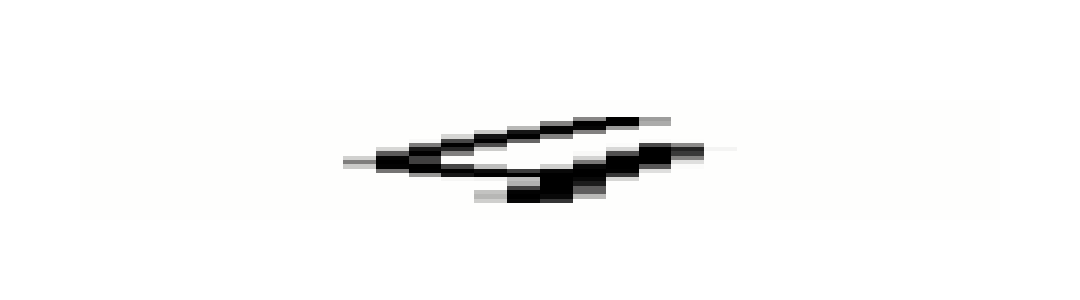

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.   0.   0.96 0.   0.   0.   0.04 0.   0.   0.  ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


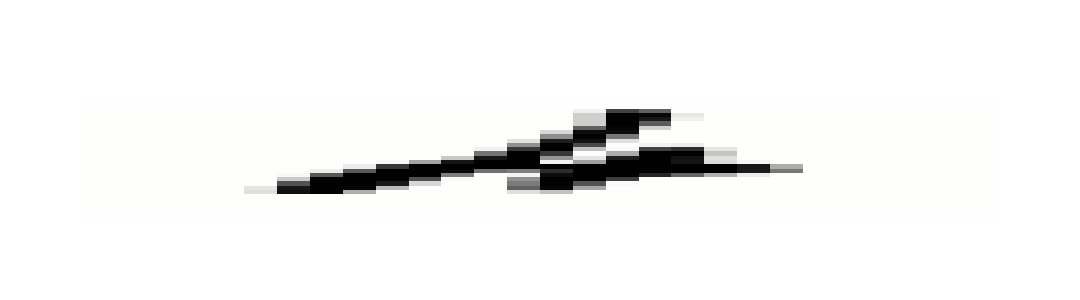

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.93 0.   0.   0.   0.   0.   0.07 0.   0.   0.  ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


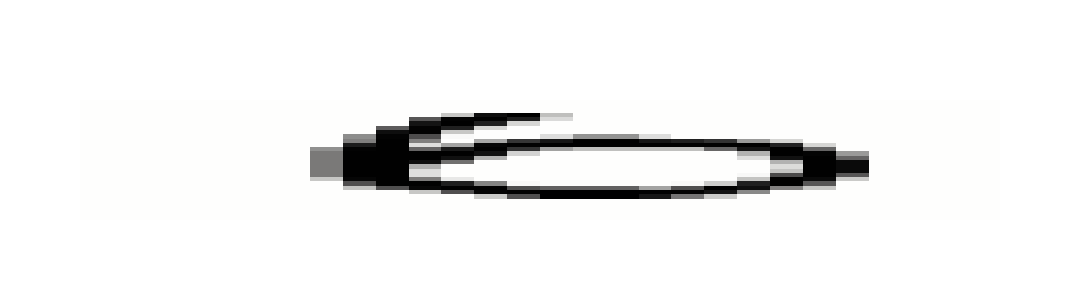

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.   0.   0.07 0.03 0.   0.   0.   0.89 0.01 0.  ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


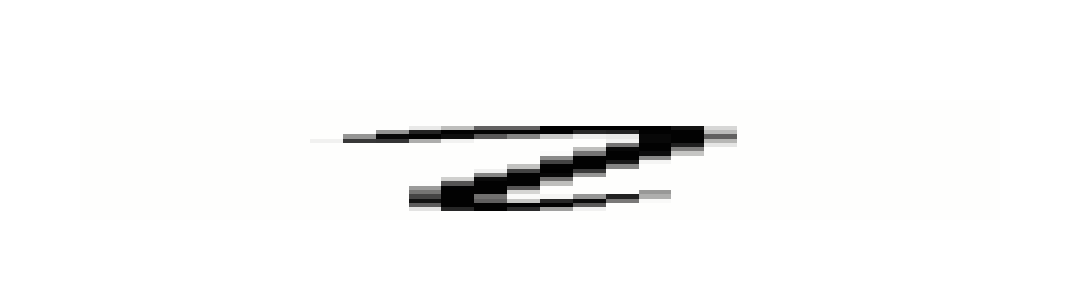

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.   0.   0.   0.79 0.   0.21 0.   0.   0.   0.  ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


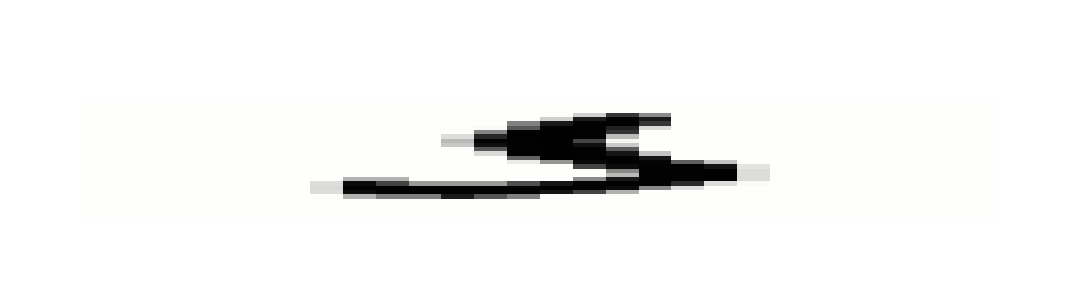

In [13]:
import plotly.graph_objects as go

misses = np.where(correct==0)[0]
for max_idx in misses[:5]:
    print(list(range(10)))
    print(np.round(softmax(result[max_idx,:]), 2))
    print(reference[max_idx])
    
    fig = go.Figure(go.Heatmap(z=test_data[max_idx,::-1,:], colorscale='gray_r', showscale=False, name="***" + str(labels[0])))
    fig.update_layout(width=300, height=300, xaxis_visible=False, yaxis_visible=False)
    fig.show()